# **Модель, распознающая эмоции**
Здесь описано создание и обучение модели, распознающей эмоции по фотографии.

## Эмоции
Модель распознает 7 базовых эмоций по Экману:
- злость (ANGER)
- отвращение (DISGUST)
- страх (FEAR)
- счастье (HAPPINESS)
- грусть (SAD)
- удивление (SURPRISE)
- нейтральное выражение (NEUTRAL)

Инициализируем массив эмоций

In [0]:
emotions = [(0, "ANGER"), (1, "DISGUST"), (2, "FEAR"), (3, "HAPPINESS"), 
            (4, "SAD"), (5, "SURPRISE"), (6, "NEUTRAL")]

## Датасет
Для обучения, будем использовать датасет fer2013. Найти его можно [здесь](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data). Загрузите его и поместите в папку с этим файлом.
Или можно примонтировать Google Drive, если используется Google Colab.

In [28]:
# Монтирование Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Путь до датасета, укажите свой
fer_dataset_path = "/content/drive/My Drive/university/reko/fer2013.csv"

## Подготовка данных
Для обучения подготавливаем данные. Грузим датасет. Изображения в датасете имеют размер 48х48 пикселей

In [0]:
import pandas as pd
import numpy as np

In [0]:
width, height = 48, 48
data = pd.read_csv(fer_dataset_path)

Данные в датасете хранятся в виде векторов целых чисел. В столбце emotion указан идентификатор эмоции (ассоциативный массив определен выше), а pixels - это 2304 (48х48) чисел изображения, пиксели. Пример как это хранится внутри csv файла ниже:

In [32]:
data[:5]

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [0]:
datapoints = data['pixels'].tolist()

all_images = []
for images in datapoints:
  # преобразуем из строки в массив чисел
  x = [int(image) for image in images.split(' ')]
  # преобразуем одномерный массив в матрицу
  x = np.asarray(x).reshape(width, height)
  # добавляем изображение в список всех изображений
  all_images.append(x.astype('float32'))

In [0]:
# преобразование к массиву numpy
all_images = np.asarray(all_images)
all_images = np.expand_dims(all_images, -1)

Считываем эмоции:

In [43]:
all_emotions = pd.get_dummies(data['emotion'])
all_emotions

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
35882,0,0,0,0,0,0,1
35883,0,0,0,1,0,0,0
35884,1,0,0,0,0,0,0
35885,0,0,0,1,0,0,0


## Модель
Для распознавания эмоций на изображении лучше всего использовать сверточную нейронную сеть. Для построения модели будем использовать Keras и TensorFlow. Делаем нужные импорты

In [0]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os

Так же задаем нужные константы

In [0]:
num_features = 64 # количество признаков
num_labels = len(emotions) # количество эмоций
batch_size = 64 # каким размером партии данных обучать
epochs = 100 # количество эпох, сколько раз обучать

Разделяем данные для теста и обучения

In [46]:
separate_index = int(len(all_images) * 0.9)
test_images, train_images = all_images[separate_index:], all_images[:separate_index]
test_emotions, train_emotions = all_emotions[separate_index:], all_emotions[:separate_index]

print("Размер тестовой подборки: {0}".format(len(test_images)))
print("Размер обучающей подборки: {0}".format(len(train_images)))

Размер тестовой подборки: 3589
Размер обучающей подборки: 32298


Сама сверточная нейронная сеть построена следующим образом

In [47]:
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)      

Модель создана, теперь следует её скопилировать и обучить.

In [0]:
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_emotions,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(test_images, test_emotions),
          shuffle=True)

Train on 32298 samples, validate on 3589 samples
Epoch 1/100
32298/32298 [==============================] - 80s 2ms/step - loss: 2.0393 - accuracy: 0.2144 - val_loss: 1.8380 - val_accuracy: 0.2452
Epoch 2/100
32298/32298 [==============================] - 78s 2ms/step - loss: 1.8358 - accuracy: 0.2475 - val_loss: 1.8243 - val_accuracy: 0.2449
Epoch 3/100
32298/32298 [==============================] - 78s 2ms/step - loss: 1.7979 - accuracy: 0.2679 - val_loss: 1.7554 - val_accuracy: 0.2917
Epoch 4/100
32298/32298 [==============================] - 78s 2ms/step - loss: 1.7117 - accuracy: 0.3074 - val_loss: 2.0654 - val_accuracy: 0.1948
Epoch 5/100
32298/32298 [==============================] - 78s 2ms/step - loss: 1.5838 - accuracy: 0.3707 - val_loss: 1.5552 - val_accuracy: 0.3918
Epoch 6/100
32298/32298 [==============================] - 77s 2ms/step - loss: 1.4993 - accuracy: 0.4152 - val_loss: 1.4685 - val_accuracy: 0.4361
Epoch 7/100
32298/32298 [==============================] - 78s 

Сохраняем модель

In [0]:
model.save("fer_model.tf")

## Тестирование
Загружаем модель с диска (если она у вас не загружена и вы не обучали модель)

In [0]:
# Укажите свой путь до обученной модели
model_path = "/content/drive/My Drive/university/reko/fer_model.tf"
model = load_model(model_path)

Проверяем работоспособность модели

In [0]:
# Индекс максимального элемента в массиве
def get_index_of_max(arr):
  return np.where(arr == max(arr))[0][0]

# Возвращает нужную эмоцию по айди
def get_emotion(index):
  for id, emotion in emotions:
    if (id == index):
      return emotion

# Возвращает айди эмоции
def get_index_by_emotion(emotion):
  for id, e in emotions:
    if (emotion == e):
      return id

# Определяет эмоцию на изображении image
def predict(image):
  image = np.array([image])
  predicted = model.predict(image)[0]
  return get_emotion(get_index_of_max(predicted))

# Убирает одно измерение в массиве
# Т.к. модели необходима форма (n, 48, 48, 1), а с последним измерением неудобно работать
# то игнорируем его и преобразуем к форме (n, 48, 48)
def collapse_dims(raw_image):
  image = []
  for column_pixels in raw_image:
    temp_column = []
    for pixel in column_pixels:
      temp_column.append(pixel[0])
    image.append(temp_column)
  return np.array(image)

# Показать изображение 
def show_image(raw_image):
  image = collapse_dims(raw_image).reshape(width, height)

  pathname = "test_image.jpg"
  cv2.imwrite(pathname, image)
  image = cv2.imread(pathname)
  plt.imshow(image)

HAPPINESS


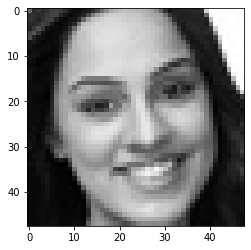

In [87]:
img = test_images[297]
print(predict(img))
show_image(img)

Составляем матрицу ошибок

In [0]:
# Возвращаем список эмоций переданных изображений
def make_emotions_list(images):
  emotions = []
  for image in images:
    emotions.append(get_emotion(get_index_of_max(image)))
  return emotions

# Вычисление матрицы ошибок
def confusion_matrix(predicted, test):
  result_matrix = []
  for key, emotion in emotions:
    counts = []

    for k, e in emotions:
      counts.append(0)

    for i in range(0, len(test)):
      if (test[i] == emotion and test[i] == predicted[i]):
        counts[key] += 1
      elif (test[i] == emotion):
        counts[get_index_by_emotion(predicted[i])] += 1

    result_matrix.append(["%.3f" % (count / sum(counts)) for count in counts])
  return result_matrix

# Вывод матрицы ошибок
def show_confusion_matrix(values):
  groups = [v for k, v in emotions]
  fig, ax = plt.subplots(figsize=(13,10))  
  sns.heatmap(values, annot=True, xticklabels=groups, yticklabels=groups, linewidths=2, cmap='Blues')

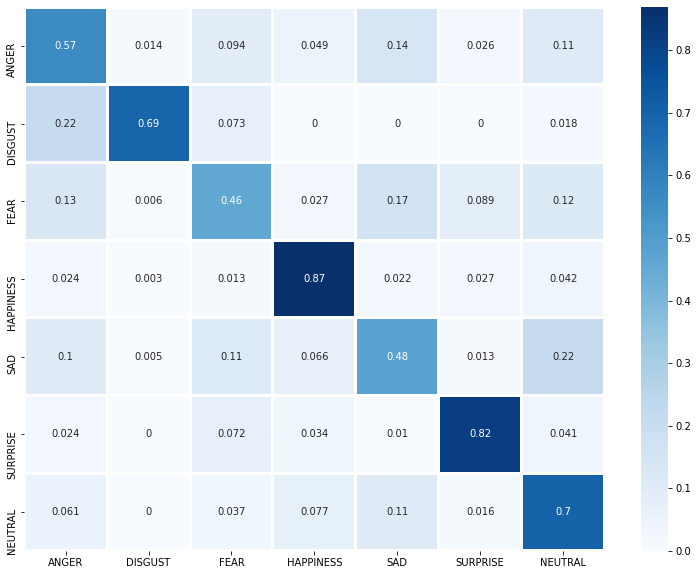

In [169]:
predicted_images = model.predict(test_images)

predicted_emotions = make_emotions_list(predicted_images)
test_emotions = [get_emotion(emotion) for emotion in data["emotion"].tolist()[separate_index:]]

values = np.array(confusion_matrix(predicted_emotions, test_emotions)).astype(np.float)
show_confusion_matrix(values)

## Конвертация в tflite
Так же можно конвертировать Keras модель в tflite.

In [23]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()
open("model.tflite", "wb").write(tfmodel)

23617716

Для использования модели tflite следует знать какой формат данных принимает модель.<br/>
**Вход**: массив матриц 48х48 пикселей<br/>
**Выход**: массив значений типа float, где наибольшее обозначает вероятную эмоцию

In [26]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

print("Формат входных данных: {0}".format(interpreter.get_input_details()[0]['shape']))
print("Тип входных данных: {0}".format(interpreter.get_input_details()[0]['dtype']))

print("Формат входных данных: {0}".format(interpreter.get_output_details()[0]['shape']))
print("Тип входных данных: {0}".format(interpreter.get_output_details()[0]['dtype']))

Формат входных данных: [ 1 48 48  1]
Тип входных данных: <class 'numpy.float32'>
Формат входных данных: [1 7]
Тип входных данных: <class 'numpy.float32'>
